# 02 - Kernel methods and SVMs
** Ecole Centrale Nantes **

** Diana Mateus **





PARTICIPANTS: **(Rebecca Teklewold & Pierrre Baptiste)**
    

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import random


from skimage.color import rgb2gray
from skimage.transform import resize

from sklearn.svm import SVC
from sklearn.utils import shuffle


# 1. Image classification on Caltech 101

**a)** Download images from
http://www.vision.caltech.edu/feifeili/Datasets.htm
and run the code bellow to check the files and store the name of the classes in the list ```labelNamesAll```

(Just run)

In [3]:
## VERIFY LOCATION AND STORE LABEL NAMES

#IMDIR = '101Caltech/101_ObjectCategories/'
#IMDIR = '101Caltech/animals10classes/'
IMDIR='Desktop/M1 CORO/ARTIN/animals10classes'


labelNamesAll = []

for root, dirnames, filenames in os.walk(IMDIR):
    labelNamesAll.append(dirnames)
    #uncomment to check what is found in this folder
    for filename in filenames:
        f = os.path.join(root, filename)
        if f.endswith(('.png', '.jpg', '.jpeg','.JPG', '.tif', '.gif')):
            print(f)

labelNamesAll = labelNamesAll[0]

#The list of all labels/directories is
print(labelNamesAll)
print(len(labelNamesAll))

Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0001.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0002.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0003.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0004.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0005.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0006.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0007.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0008.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0009.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0010.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0011.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0012.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0013.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0014.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0015.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0016.jpg
Desktop/M1 CORO/ARTIN/animals10classes\ant\image_0017.jpg
Desktop/M1 COR

**b. Build a reduced dataset for accelerating process.** To do so: 
- Consider only up to $K$ randomly drawn categories (start with a binary case)
- Read only up to $N$ images for each class
- Resize the images to $(imWidth*imHeight)$

The dataset should consist of a 
- Input matrix $\mathbf{X}$ of size $(K\cdot N)\times (imWidth\cdot imHeight)$ with one image in every row of the matrix. 
- Output vector $\mathbf{y}$ of size $(K\cdot N)\times 1$ with the label index of each input point in $\bf X$.
- the reduced list of the label names of size $K$ to map between the indices and the names.

**Note than different classes may have different number of images so that the actual number of $\bf X$ and $\bf y$ is less than $K*N$**

(Run and try to understand the structure of the data)

In [4]:
#build DATASET from K categories and (up to) N images from category
K = 2
N = 40
imWidth = 100
imHeight = 100

#selection of label indices
X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
#Y = np.zeros([K*N,1]) #label indices
Y = -np.ones([K*N,1]) #label indices
labelNames = []

#random.seed(a=42)


globalCount = 0
for i in range(K): 
    while True:
        lab = random.randint(0,len(labelNamesAll)-1)
        if lab not in labelNames:
            break
    #folders are named after the class label
    filedir = os.path.join(IMDIR,labelNamesAll[lab])
    print(filedir)

    #save the name of the class
    labelNames.append(labelNamesAll[lab])       

    classCount = 0
    for filename in os.listdir(filedir):
        f = os.path.join(filedir, filename)
        if f.endswith(('.jpg')) and (classCount < N):
            #image = skimage.io.imread(f, as_grey=True) #Try this line instead of the one below if there is an error
            image = skimage.io.imread(f, as_gray=True)
            image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
            X[globalCount,:] = image.flatten()
            Y[globalCount,:] = i
            globalCount += 1
            classCount += 1

#Remove the unused entries of X and Y
print(globalCount)
X = X[:globalCount,:]
Y = Y[:globalCount,:]

#Check the stored classes
print(labelNames)
print(X.shape)
print(Y.T)


Desktop/M1 CORO/ARTIN/animals10classes\dragonfly
Desktop/M1 CORO/ARTIN/animals10classes\ant
80
['dragonfly', 'ant']
(80, 10000)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1.]]


**c**. Split the dataset into train (80% of samples) and test (20% samples). 
(Run and try to understand the structure of the data)

In [5]:
# Split in Train and test set with 80% - 20% rule

Ntrain = np.rint(.8*Y.shape[0]).astype(int)
Ntest = Y.shape[0]-Ntrain
print('Training with', Ntrain , 'training samples and ', Ntest, 'testing samples.')

# Randomize the order of X and Y
X, Y = shuffle(X, Y, random_state=0)


# Split the data and labels into training/testing sets
X_train = X[0:Ntrain,:]
Y_train = Y[0:Ntrain,:]

X_test = X[Ntrain:,:]
Y_test = Y[Ntrain:,:]

print(X_train.shape)
print(X_test.shape)
print(Y_train.T)
print(Y_test.T)

Training with 64 training samples and  16 testing samples.
(64, 10000)
(16, 10000)
[[1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 1. 1.
  1. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0.
  0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 0. 0.]]
[[0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.]]


**d) Training and testing a SVM
- Create an SVC model using the sklearn module, 
- train it on the train set, 
- and test it on the test set**. 

(Fill in the code and answer the questions)

**Question** SVMs are intrinsically binary classifiers, can you train the SVC for K>2? How is that achieved?

**ANSWER**: Fill your answer here 

**Answer is on the report**

In [6]:
# Create, train and test an svm model using the sklearn SVC
from sklearn.svm import SVC
model=SVC(kernel='linear')
model.fit(X_train,Y_train.ravel())
Y_pred=model.predict(X_test)

# FILL YOUR CODE HERE 


print("True classes",Y_test.T)
print("Predictions",Y_pred)
errors = np.sum((Y_test.ravel()!=Y_pred))
print('There were ', errors, 'errors')

True classes [[0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.]]
Predictions [0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1.]
There were  9 errors


**e) Fill in the functions bellow to computing different evaluation measures and give a performance report**
Look at the formulas and definitions in https://en.wikipedia.org/wiki/Evaluation_measures_(information_retrieval)

Start by computing the confusion matrix, and the values TP, TN, FP, FN, for a binary case. When considering multiple clases ($K>2$) treat one class at a time as the postive class, and the remaining classes as negative. You may want to indicate the positive class as a parameter to the indicator function.

**Question:** There are two ways of resuming the scores for a multiple class problem $K>2$, namely, the macroaverage and the microaverage. Implement and EXPLAIN them below.

**Hint** Add a numerical zero eps to the denominators to prevent dividing by zero

**ANSWER** Write your answer in the report

In [7]:
# Functions to compute the errors between prediction and ground truth 

def compute_measures(Y_grt,Y_pred,k): #Y_gt = ground truth
    measures = dict()
    Y_len = len(Y_grt)
    
    eps = 1e-12
    
    TP = eps
    TN = eps
    FP = eps
    FN = eps
    for i in range(Y_len):
        if Y_grt[i]==k and Y_pred[i]==k:  # True positives TP
            TP+=1
        if Y_grt[i]!=k and Y_pred[i]!=k:  # True negatives TN
            TN+=1
        if Y_grt[i]!=k and Y_pred[i]==k:   # False positives FP
            FP+=1
        if Y_grt[i]==k and Y_pred[i]!=k:  # False negatives FN
            FN+=1

    print('TP ', TP, 'TN ', TN, 'FP', FP, 'FN', FN, 'Total', TP+TN+FP+FN)
    measures['TP'] = TP
    measures['TN'] = TN
    measures['FP'] = FP
    measures['FN'] = FN
    
    
    # Accuracy
    measures['accuracy'] = (TP+TN)/(TP+TN+FP+FN)
    
    # Precision
    measures['precision'] = TP/(TP+FP)
        
    # Specificity
    measures['specificity']=TN/(TN+FP)
    
    # Recall
    measures['recall'] = TP/(TP+FN)
    
    # F-measure
    measures['f1'] = 2*measures['precision']* measures['recall']/(measures['precision']+measures['recall'])
    
    # Negative Predictive Value
    measures['npv'] = TN/(TN+FN)
    
    # False Predictive Value
    measures['fpr'] = FP/(FP+TN)
    
    print('Accuracy ', measures['accuracy'], '\n',
          'Precision', measures['precision'], '\n',
          'Recall', measures['recall'], '\n',
          'Specificity ', measures['specificity'], '\n',
          'F-measure', measures['f1'], '\n',
          'NPV', measures['npv'],'\n',
          'FPV', measures['fpr'],'\n')


    
    return measures

def micro_average(measuresList):
    microAverage = dict()
    eps = 1e-12
    
    TP_values=[eps]
    TN_values=[eps]
    FP_values=[eps]
    FN_values=[eps]
    for i in range(len(measuresList)):
        for key, value in measuresList[i].items():
            if key=='TP':
                 TP_values.append(value)
            if key=='TN':
                 TN_values.append(value)
            if key=='FP':
                 FP_values.append(value)
            if key=='FN':
                 FN_values.append(value)
    # Accuracy
    microAverage['accuracy'] = (sum(TP_values)+sum(TN_values))/(sum(TP_values)+sum(TN_values)+sum(FP_values)+sum(FN_values))
    
    # Precision
    microAverage['precision'] = sum(TP_values)/(sum(TP_values)+sum(FP_values))
        
    # Specificity
    microAverage['specificity'] = sum(TN_values)/(sum(FP_values)+sum(TN_values))
    
    # Recall
    microAverage['recall'] = sum(TP_values)/(sum(TP_values)+sum(FN_values))
    
    # F-measure
    microAverage['f1'] = 2*sum(TP_values)/(2*sum(TP_values)+sum(FP_values)+sum(FN_values))
    
    # Negative Predictive Value
    microAverage['npv'] = sum(TN_values)/(sum(FN_values)+sum(TN_values))
    
    # False Predictive Value
    microAverage['fpr'] = sum(FP_values)/(sum(FP_values)+sum(TN_values))
    
        
    print('Accuracy ', microAverage['accuracy'], '\n',
          'Precision', microAverage['precision'], '\n',
          'Recall', microAverage['recall'], '\n',
          'Specificity ', microAverage['specificity'], '\n',
          'F-measure', microAverage['f1'], '\n',
          'NPV', microAverage['npv'],'\n',
          'FPV', microAverage['fpr'],'\n')
    
    return microAverage

def macro_average(measuresList):
    macroAverage = dict()
    eps = 1e-12
    

    # Accuracy
    accuracy_values=[eps]
    for i in range(len(measuresList)):
        for key, value in measuresList[i].items():
            if key=='accuracy':
                 accuracy_values.append(value)
    macroAverage['accuracy']=sum(accuracy_values)/len(accuracy_values)        
#accuracy_values =[value for name, value in measuresList[i].items if name=='accuracy']
    # Precision
    precision_values=[eps]
    for i in range(len(measuresList)):
        for key, value in measuresList[i].items():
            if key=='precision':
                 accuracy_values.append(value)
    macroAverage['precision']=sum(precision_values)/len(precision_values)  
    
    # Specificity
    specificity_values=[eps]
    for i in range(len(measuresList)):
        for key, value in measuresList[i].items():
            if key=='specificity':
                 specificity_values.append(value)
    macroAverage['specificity']=sum(specificity_values)/len(specificity_values)  
    
    # Recall
    recall_values=[eps]
    for i in range(len(measuresList)):
        for key, value in measuresList[i].items():
            if key=='recall':
                 recall_values.append(value)
    macroAverage['recall']=sum(recall_values)/len(recall_values)  
    
    # F-measure
    f1_values=[eps]
    for i in range(len(measuresList)):
        for key, value in measuresList[i].items():
            if key=='f1':
                 f1_values.append(value)
    macroAverage['f1']=sum(f1_values)/len(f1_values)  
        
    # Negative Predictive Value
    npv_values=[eps]
    for i in range(len(measuresList)):
        for key, value in measuresList[i].items():
            if key=='npv':
                 npv_values.append(value)
    macroAverage['npv']=sum(npv_values)/len(npv_values) 
    
    # False Predictive Value
    fpr_values=[eps]
    for i in range(len(measuresList)):
         for key, value in measuresList[i].items():
            if key=='fpr':
                 fpr_values.append(value)
    macroAverage['fpr']=sum(fpr_values)/len(fpr_values) 

    
    print('Accuracy ', macroAverage['accuracy'], '\n',
          'Precision', macroAverage['precision'], '\n',
          'Recall', macroAverage['recall'], '\n',
          'Specificity ', macroAverage['specificity'], '\n',
          'F-measure', macroAverage['f1'], '\n',
          'NPV', macroAverage['npv'],'\n',
          'FPV', macroAverage['fpr'],'\n')
    
    return macroAverage



**e)** Measure the performance of the SVC model for multiple classes $K>2$

First collect the measures when considering each class as positive, then, compute macro and microaverage 

Compare your results to those of sklearn metrics. 

In [9]:
#Fill in a list of measure dictionaries taking as input a different positive class

multiclass = []
K=2
for k in range(K):
    print('For class',labelNames[k])
    multiclass.append(compute_measures(Y_test.ravel(),Y_pred,k))

print('Macro-average')
macro_average(multiclass)
    
print('Micro-average')
micro_average(multiclass)


from sklearn.metrics import classification_report #confusion_matrix, accuracy_score, precision_score, recall_score, f1_micro, f1_macro
print(classification_report(Y_test.ravel(), Y_pred, target_names=labelNames))

For class dragonfly
TP  5.000000000001 TN  2.000000000001 FP 7.000000000001 FN 2.000000000001 Total 16.000000000004
Accuracy  0.4375000000000156 
 Precision 0.41666666666668056 
 Recall 0.714285714285653 
 Specificity  0.22222222222228397 
 F-measure 0.5263157894736786 
 NPV 0.5 
 FPV 0.7777777777777161 

For class ant
TP  2.000000000001 TN  5.000000000001 FP 2.000000000001 FN 7.000000000001 Total 16.000000000004
Accuracy  0.4375000000000156 
 Precision 0.5 
 Recall 0.22222222222228397 
 Specificity  0.714285714285653 
 F-measure 0.3076923076923669 
 NPV 0.41666666666668056 
 FPV 0.2857142857143469 

Macro-average
Accuracy  0.2916666666670104 
 Precision 1e-12 
 Recall 0.31216931216964566 
 Specificity  0.31216931216964566 
 F-measure 0.2780026990556818 
 NPV 0.30555555555589353 
 FPV 0.35449735449768766 

Micro-average
Accuracy  0.4375000000000234 
 Precision 0.4375000000000234 
 Recall 0.4375000000000234 
 Specificity  0.4375000000000234 
 F-measure 0.4375000000000234 
 NPV 0.4375000

**f) Show the test images as well as the the predictions (Y_pred) vs the ground truth (Y_gt) labels for the best model**
(Just run for each analysed model)

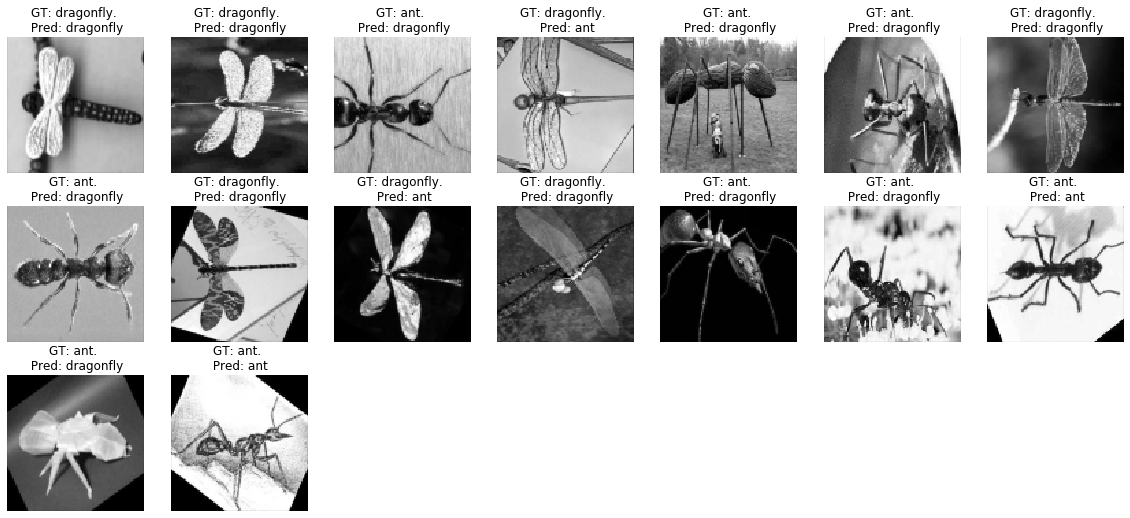

In [10]:
# Show some results
width=20
height=15
plt.rcParams['figure.figsize'] = [width, height]
fig=plt.figure()
imCounter = 1
for i in range(len(Y_test)):
    image=np.reshape(X_test[i,:], (imHeight,imWidth)) 

    plt.subplot(5,7,imCounter)
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    gtLabel = labelNames[Y_test.ravel()[i].astype(int)]
    predLabel = labelNames[Y_pred.ravel()[i].astype(int)]
    plt.title('GT: {}. \n Pred: {}'.format(gtLabel, predLabel))

    imCounter += 1
plt.show()


** g) REPORT:**  Change the kernel and other hyperparameters of your SVC trying to optimize the F1 measure for different cases. Describe in your report the different variants of the model tried. You may want to split your dataset into train, validation and test sets. Present and discuss your findings for different hyperparameters, number of classes and numbers of images. THIS IS THE MOST IMPORTANT PART FOR THE EVALUATION. 

In [13]:
K = 3
N = 50
imWidth = 100
imHeight = 100

#selection of label indices
New_X = np.zeros([K*N,imHeight*imWidth]) #data matrix, one image per row
#Y = np.zeros([K*N,1]) #label indices
New_Y = -np.ones([K*N,1]) #label indices
New_labelNames = []

#random.seed(a=42)


globalCount = 0
for i in range(K): 
    while True:
        lab = random.randint(0,len(labelNamesAll)-1)
        if lab not in New_labelNames:
            break
    #folders are named after the class label
    filedir = os.path.join(IMDIR,labelNamesAll[lab])
    print(filedir)

    #save the name of the class
    New_labelNames.append(labelNamesAll[lab])       

    classCount = 0
    for filename in os.listdir(filedir):
        f = os.path.join(filedir, filename)
        if f.endswith(('.jpg')) and (classCount < N):
            #image = skimage.io.imread(f, as_grey=True) #Try this line instead of the one below if there is an error
            image = skimage.io.imread(f, as_gray=True)
            image = skimage.transform.resize(image, [imHeight,imWidth],mode='constant')#,anti_aliasing=True)
            New_X[globalCount,:] = image.flatten()
            New_Y[globalCount,:] = i
            globalCount += 1
            classCount += 1

#Remove the unused entries of X and Y
print(globalCount)
New_X =New_X[:globalCount,:]
New_Y =New_Y[:globalCount,:]

#Check the stored classes
print(New_labelNames)
print(New_X.shape)
print(New_Y.T)


Desktop/M1 CORO/ARTIN/animals10classes\crocodile
Desktop/M1 CORO/ARTIN/animals10classes\sea_horse
Desktop/M1 CORO/ARTIN/animals10classes\flamingo
150
['crocodile', 'sea_horse', 'flamingo']
(150, 10000)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
  2. 2. 2. 2. 2. 2.]]


In [14]:
from sklearn.model_selection  import train_test_split

New_X_train,New_X_rem,New_Y_train,New_Y_rem=train_test_split(New_X,New_Y,train_size=0.8)
New_X_valid,New_X_test,New_Y_valid,New_Y_test=train_test_split(New_X_rem,New_Y_rem,train_size=0.5)
# Randomize the order of X and Y

#New_X, New_Y = shuffle(New_X, New_Y, random_state=0)
print(New_X_train.shape)
print(New_X_valid.shape)
print(New_X_test.shape)
print(New_Y_train.T)
print(New_Y_valid.T)
print(New_Y_test.T)

(120, 10000)
(15, 10000)
(15, 10000)
[[0. 0. 2. 2. 1. 2. 0. 1. 1. 2. 1. 1. 0. 0. 0. 1. 2. 1. 0. 1. 1. 1. 2. 0.
  1. 1. 0. 0. 1. 2. 1. 0. 1. 0. 1. 0. 2. 2. 1. 2. 1. 0. 1. 1. 2. 0. 0. 0.
  0. 2. 1. 2. 0. 2. 1. 0. 2. 0. 2. 1. 1. 2. 2. 2. 2. 0. 1. 1. 0. 1. 2. 2.
  0. 1. 0. 2. 1. 1. 2. 2. 2. 2. 2. 0. 2. 2. 0. 2. 0. 2. 2. 1. 0. 1. 0. 2.
  2. 2. 1. 2. 0. 1. 1. 2. 0. 0. 0. 1. 0. 0. 1. 2. 0. 1. 0. 2. 0. 2. 2. 0.]]
[[2. 0. 0. 1. 0. 0. 2. 1. 1. 0. 0. 1. 1. 0. 2.]]
[[1. 1. 2. 1. 1. 1. 2. 1. 2. 0. 0. 0. 1. 2. 2.]]


In [15]:
def find_score(report_list):
    accuracy_score=[]
    macro_avg_score=[]
    weighted_avg_score=[]
    for i in range(len(report_list)):
        accuracy_score.append(report_list[i]['accuracy'])
        macro_avg_score.append(report_list[i]['macro avg']['f1-score'])
        weighted_avg_score.append(report_list[i]['weighted avg']['f1-score'])
    total_score=[accuracy_score,macro_avg_score,weighted_avg_score]
    return total_score
        

In [16]:
#plot values
def plot_scores(report_list,params,xlabel):
    fig=plt.figure(figsize=(7.4,3.4))
    ax=fig.add_axes([0,0,1,1])
    #params=['0.0001','0.001','0.01','0.1','1','10','100']
    X=np.arange(len(params))
    data=find_score(report_list)
    ax.bar(X+0.00, data[0],color='b',width=0.25)
    ax.bar(X+0.25, data[1],color='r',width=0.25)
    ax.bar(X+0.50, data[2],color='g',width=0.25)
    ax.set_xticks(np.arange(len(params)))
    ax.set_xticklabels(params,fontsize=10)
    ax.set_ylabel('Scores',fontsize=18)
    ax.set_xlabel(xlabel,fontsize=18)
    ax.legend(labels=['accuracy','macro avg','weighted avg'],fontsize=12)
    #ax.set_title('Influence of gamma on rbf kernel', fontsize=20)
    plt.show()
    
    
    

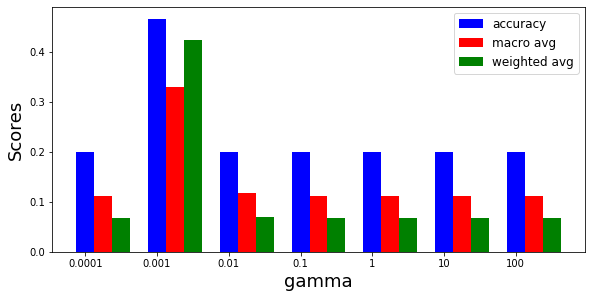

In [17]:
#changing the value of gamma for rbf 
gamma=[0.0001,0.001,0.01,0.1,1,10,100]
report_list_gamma_rbf=[]
for i in range(len(gamma)):
    model=SVC(kernel='rbf',gamma=gamma[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_gamma_rbf.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_gamma_rbf,gamma,'gamma')
fig.savefig('gamma6 influence on rbf.png')    

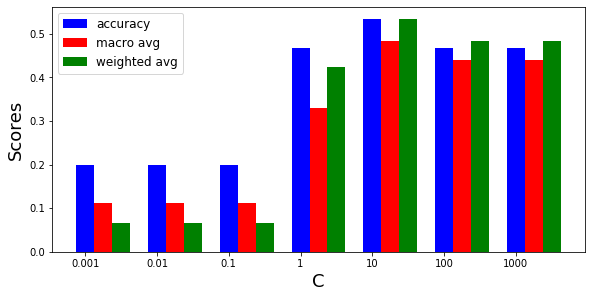

In [18]:
#changing C values for rbf kernel
C=[0.001,0.01,0.1,1,10,100,1000]
report_list_C_rbf=[]
for i in range(len(C)):
    model=SVC(kernel='rbf',C=C[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_C_rbf.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_C_rbf,C,'C')
fig.savefig('C6 influence on rbf.png')   

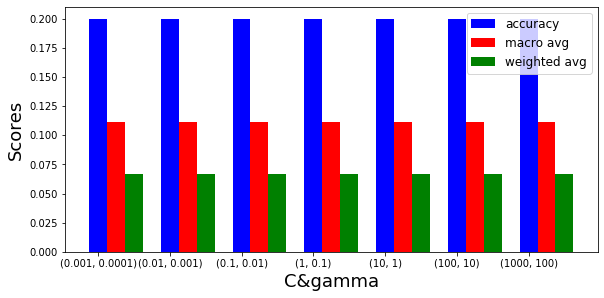

In [19]:
#combining small c with small gamma
C=[0.001,0.01,0.1,1,10,100,1000]
gamma=[0.0001,0.001,0.01,0.1,1,10,100]
params=[(C[0],gamma[0]),(C[1],gamma[1]),(C[2],gamma[2]),(C[3],gamma[3]), (C[4],gamma[4]),(C[5],gamma[5]),(C[6],gamma[6])]
report_list_C_vs_gamma_rbf=[]
for i in range(len(params)):
    model=SVC(kernel='rbf',gamma=gamma[i],C=C[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_C_vs_gamma_rbf.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_C_vs_gamma_rbf,params,'C&gamma')
fig.savefig('C&gamma6 influence on rbf.png')  

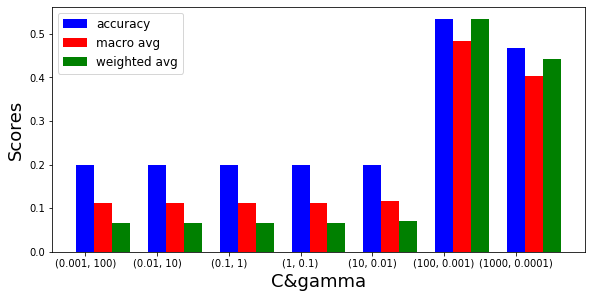

In [20]:
#influence of combining small C and large gamma and vice versa
C=[0.001,0.01,0.1,1,10,100,1000]
gamma=[100,10,1,0.1,0.01,0.001,0.0001]
params=[(C[0],gamma[0]),(C[1],gamma[1]),(C[2],gamma[2]),(C[3],gamma[3]), (C[4],gamma[4]),(C[5],gamma[5]),(C[6],gamma[6])]
report_list_Csmall_vs_gammalarge_rbf=[]
for i in range(len(params)):
    model=SVC(kernel='rbf',gamma=gamma[i],C=C[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_Csmall_vs_gammalarge_rbf.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_Csmall_vs_gammalarge_rbf,params,'C&gamma')
fig.savefig('Csmall vs gammalarge6 influence on rbf.png')  

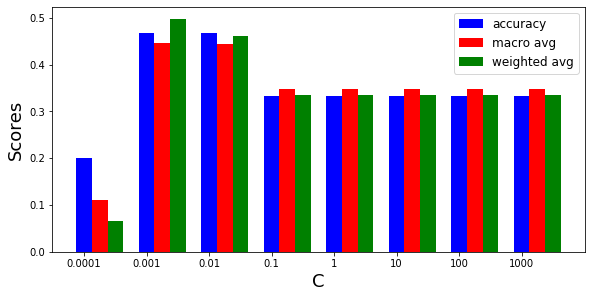

In [21]:
#changing c on a linear kernel
C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
#gamma=[100,10,1,0.1,0.01,0.001,0.0001]
#params=[(C[0],gamma[0]),(C[1],gamma[1]),(C[2],gamma[2]),(C[3],gamma[3]), (C[4],gamma[4]),(C[5],gamma[5]),(C[6],gamma[6])]
report_list_C_linear=[]
for i in range(len(C)):
    model=SVC(kernel='linear',C=C[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_C_linear.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_C_linear,C,'C')
fig.savefig('C6 influence on linear.png') 

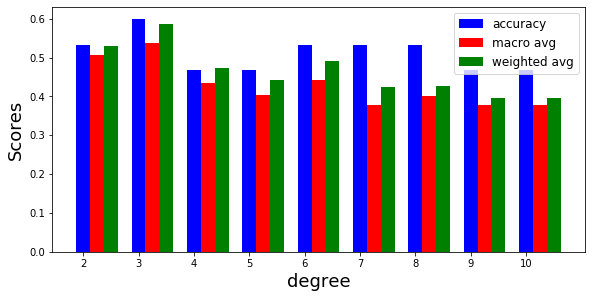

In [22]:
#degree influence on polynomial kernel
degree=[2,3,4,5,6,7,8,9,10]
report_list_degree_poly=[]
for i in range(len(degree)):
    model=SVC(kernel='poly',degree=degree[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_degree_poly.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_degree_poly,degree,'degree')
fig.savefig('degree6 influence on poly.png')

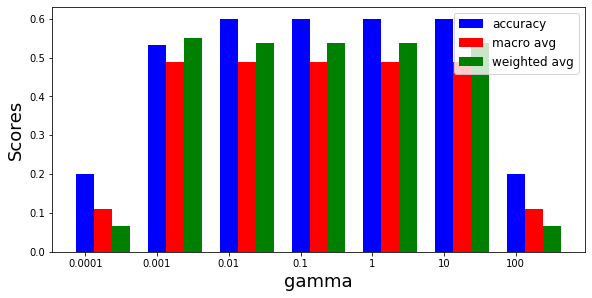

In [24]:
#gamma influence on polynomial kernel
gamma=[0.0001,0.001,0.01,0.1,1,10,100]
report_list_gamma_poly=[]
for i in range(len(gamma)):
    model=SVC(kernel='poly',degree=7,gamma=gamma[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_gamma_poly.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_gamma_poly,gamma,'gamma')
fig.savefig('gamma influence on poly.png')

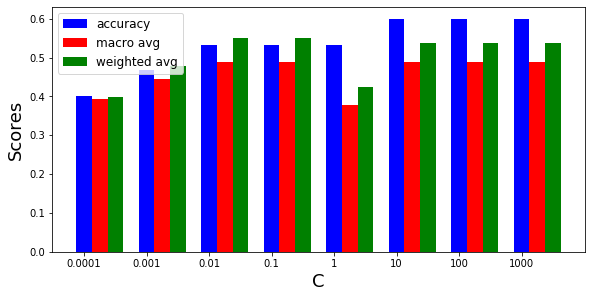

In [26]:
C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
report_list_C_poly=[]
for i in range(len(C)):
    model=SVC(kernel='poly',degree=7,C=C[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_C_poly.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_C_poly,C,'C')
fig.savefig('C6 influence on poly.png')

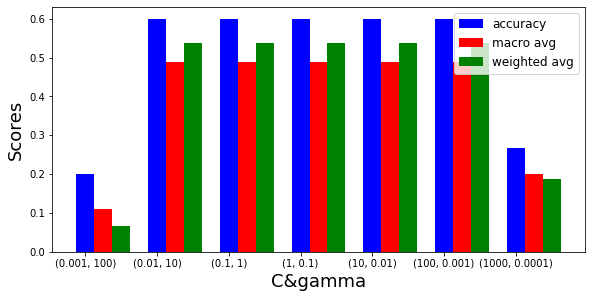

In [27]:
#changing both gamma and c for poly degree 7
C=[0.001,0.01,0.1,1,10,100,1000]
gamma=[100,10,1,0.1,0.01,0.001,0.0001]
params=[(C[0],gamma[0]),(C[1],gamma[1]),(C[2],gamma[2]),(C[3],gamma[3]), (C[4],gamma[4]),(C[5],gamma[5]),(C[6],gamma[6])]
report_list_Csmall_vs_gammalarge_poly=[]
for i in range(len(params)):
    model=SVC(kernel='poly',degree=7,gamma=gamma[i],C=C[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_Csmall_vs_gammalarge_poly.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_Csmall_vs_gammalarge_poly,params,'C&gamma')
fig.savefig('Csmall vs gammalarge6 influence on poly.png') 

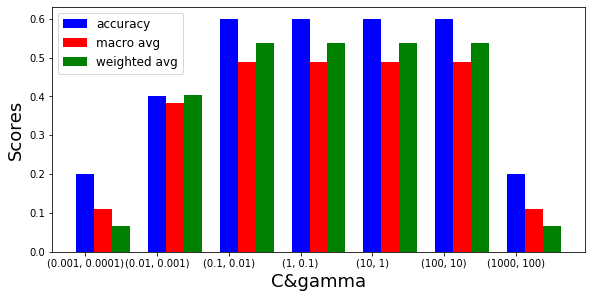

In [28]:
#changing both gamma and c for poly degree 7
C=[0.001,0.01,0.1,1,10,100,1000]
gamma=[0.0001,0.001,0.01,0.1,1,10,100]
params=[(C[0],gamma[0]),(C[1],gamma[1]),(C[2],gamma[2]),(C[3],gamma[3]), (C[4],gamma[4]),(C[5],gamma[5]),(C[6],gamma[6])]
report_list_Csmall_vs_gammasmall_poly=[]
for i in range(len(params)):
    model=SVC(kernel='poly',degree=7,gamma=gamma[i],C=C[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_Csmall_vs_gammasmall_poly.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_Csmall_vs_gammasmall_poly,params,'C&gamma')
fig.savefig('Csmall vs gammasmall6  influence on poly.png') 

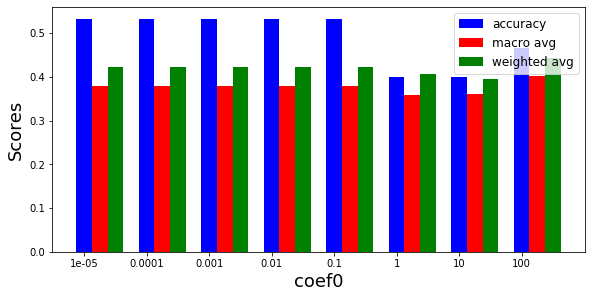

In [29]:
#changing coef0 for polynomial degree 7
coef0=[0.00001,0.0001,0.001,0.01,0.1,1,10,100]
report_list_coef0_poly=[]
for i in range(len(coef0)):
    model=SVC(kernel='poly',degree=7,coef0=coef0[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_coef0_poly.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_coef0_poly,coef0,'coef0')
fig.savefig('coef0 influence on poly.png')

In [ ]:
#changing gamma for sigmoid
gamma=[0.0001,0.001,0.01,0.1,1,10,100,1000]
report_list_gamma_sigmoid=[]
for i in range(len(gamma)):
    model=SVC(kernel='sigmoid',gamma=gamma[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_gamma_sigmoid.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_gamma_sigmoid,gamma,'gamma')
fig.savefig('gamma influence on poly.png')

In [ ]:
C=[0.0001,0.001,0.01,0.1,1,10,100,1000]
report_list_C_sigmoid=[]
for i in range(len(C)):
    model=SVC(kernel='sigmoid',C=C[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_C_sigmoid.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_C_sigmoid,C,'C')
fig.savefig('C influence on poly.png')

In [ ]:
coef0=[0.0001,0.001,0.01,0.1,1,10,100,1000]
report_list_coef0_sigmoid=[]
for i in range(len(coef0)):
    model=SVC(kernel='sigmoid',coef0=coef0[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_coef0_sigmoid.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_coef0_sigmoid,coef0,'coef0')
fig.savefig('coef0 influence on poly.png')

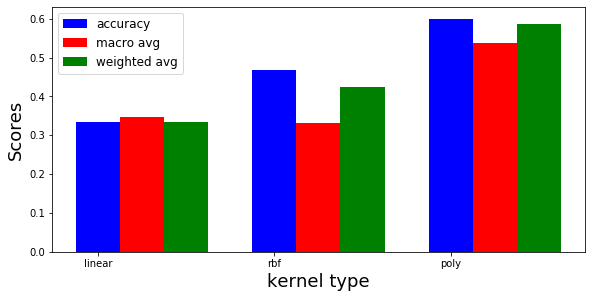

In [30]:
kernel=['linear','rbf','poly']
report_list_kernels=[]
for i in range(len(kernel)):
    model=SVC(kernel=kernel[i])
    model.fit(New_X_train,New_Y_train.ravel())
    New_Y_pred=model.predict(New_X_valid)
    report_list_kernels.append(classification_report(New_Y_valid.ravel(),New_Y_pred.ravel(), target_names=New_labelNames,output_dict=True,zero_division=1))
plot_scores(report_list_kernels,kernel,'kernel type')
fig.savefig('kernel6 influence.png')